**Neural networks for road segmentation**
========================

Your next task is to train neural network to segment road on images from car cams.

The original dataset is provided by Karlsruhe Institute of Technology (http://www.cvlibs.net/datasets/kitti/eval_road.php). Their images are ±370x1270, but, for simlictiy, we will use 370x370 squares.

One can download the dataset from https://disk.yandex.ru/d/QPOw4hk84-se_w

Here is an example of input data with corresponding ground truth:

In [1]:
import os
import cv2
import numpy as np

import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_paths(path):
    _, _, filenames = next(os.walk(path))

    images_paths = []
    for filename in sorted(filenames):            
        images_paths.append(os.path.join(path, filename))
    
    return np.stack(images_paths)

class RoadDataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, images, masks, transform, aug=None,):
        self.images = sorted(images)
        self.masks = sorted(masks)
        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        im_name = self.images[idx]
        mask_name = self.masks[idx]
        
        image = cv2.imread(im_name)[:,:,::-1] / 255.0  # ::-1 to convert from BGR to RGB
        mask = cv2.imread(mask_name, cv2.IMREAD_GRAYSCALE)
        mask = (mask > 0).astype(np.float32)
        image = image.astype(np.float32)
        
        if self.aug:
            sample = self.aug(
                image=image,
                mask=mask,
            )
        else:
            sample = {
                'image': image,
                'mask': mask,
            }
        
        sample['image'] = self.transform(sample['image']).float()
        sample['mask'] = self.transform(sample['mask']).float()

        return sample

In [3]:
X_train = get_paths("data/train/images")
y_train = get_paths("data/train/gt")

transform = transforms.Compose([
    transforms.ToTensor(),
])

In [4]:
train_dataset = RoadDataset(X_train, y_train, transform)

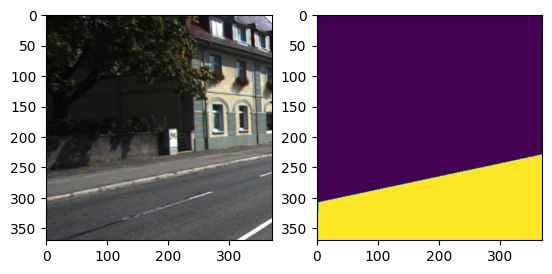

In [5]:
sample = train_dataset[110]
image = sample['image']
mask = sample['mask']

plt.subplot(1, 2, 1)
plt.imshow(image.permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask.permute(1, 2, 0))

Workflow:
---
* Choose correct loss function, write training loop and code for testing. Feel free to use previous HW for inspiration. 
* Train any segmentation neural network from scratch (for example U-Net) and achieve >= 0.75 IoU on test set (40% points). See function to calculate the metric below.
* Use any pretrained model for image classification, convert it for segmentation by adding decoder (don't forget skip-connections) or usign dilated convolutions and achieve >= 0.87 IoU  on test set (60% points).

You're not allowed to do only one thing: train your network on test set.

----
Your final solution will consist of an ipython notebook with code (for final networks training + any experiments with data) and test metric calculation.

Feel free to ask in Telegram chat if something is not clear :3


In [6]:
print(f"Dataset length {len(train_dataset)}")

Dataset length 648


Dataset is small so actively use data augmentation: rotations, flip, color-change etc. to prevent overfitting.

Most likely you'll have to pad your images to 512x512 (it divides by 2^5=32, like U-Net wants). Use PadIfNeeded from Albumentations and central crop (see below) after prediction to calculate loss/metrics (you don't want to pay attention on padded values).

----
There is a hard data class imbalance in dataset, so the network output will be biased toward "zero" class. You can either tune the minimal probability threshold for the "road" class, or add class weights in optimized loss. You also can try to use softIoU or DICE loss.

Good luck!

In [7]:
def calc_iou(prediction, ground_truth):
    n_images = len(prediction)
    intersection, union = 0, 0
    for i in range(n_images):
        intersection += np.logical_and(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum() 
        union += np.logical_or(prediction[i] > 0, ground_truth[i] > 0).astype(np.float32).sum()
    return float(intersection) / (union + 1e-6)

In [8]:
def central_crop(images, size=370):
    current_size = images.size(2)
    border_len = (current_size - size) // 2
    new_images = images[:, :, border_len:current_size-border_len, border_len:current_size-border_len]
    return new_images

# Let's try achieve > 0.75 IOU with UNet

In [9]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

In [10]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_ch
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_ch, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_ch, out_ch)
        )
    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch)
    def forward(self, x1, x2):
        x = torch.cat([x2, self.up(x1)], dim=1)
        x = self.conv(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv_sigm = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.conv_sigm(x)


class Unet(nn.Module):
    def __init__(self, in_ch=3, n_classes=1):
        super().__init__()
        self.inconv = DoubleConv(in_ch, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outconv = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inconv(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outconv(x)
        return x

In [14]:
import albumentations as A

X_train = get_paths("data/train/images/")
y_train = get_paths("data/train/gt")
X_test = get_paths("data/test/images/")
y_test = get_paths("data/test/gt")

augs = A.Compose([
    A.PadIfNeeded(min_height=512, min_width=512, border_mode=0)
])

train_dataset = RoadDataset(X_train, y_train, transform, augs)
test_dataset = RoadDataset(X_test, y_test, transform, augs)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

print(f"Train Dataset size {len(train_dataset)}")
print(f"Test Dataset size {len(test_dataset)}")

Train Dataset size 648
Test Dataset size 219


In [15]:
class DICELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth
    def forward(self, inputs, targets):
        dice = (2 * (inputs * targets).sum() + self.smooth) / (inputs.sum() + (targets).sum() + self.smooth)  
        return 1 - dice 

In [16]:
def train_model(model, loader, opt, loss_fn, predictions_thr, device, crop_size=370, opt_step=1):
    losses, ious = [], []
    model.train()
    for i, batch in enumerate(loader):
        if i % opt_step == 0:
            opt.zero_grad()
        images, masks = batch['image'].to(device), batch['mask'].to(device)        
        predictions = model(images)
        predictions, masks = central_crop(predictions, crop_size), central_crop(masks, crop_size)
        loss = loss_fn(predictions, masks)
        loss.backward()
        iou = calc_iou(predictions.detach().cpu().numpy() > predictions_thr, masks.detach().cpu().numpy())
        losses.append(loss.item())         
        ious.append(iou.item())
        if i % opt_step == 0:
            opt.step()
    return np.mean(losses), np.mean(ious) 

def eval_model(model, loader, loss_fn, predictions_thr, device, crop_size=370):
    losses, ious = [], []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            images, masks = batch['image'].to(device), batch['mask'].to(device)        
            predictions = model(images)
            predictions, masks = central_crop(predictions, crop_size), central_crop(masks, crop_size)
            loss = loss_fn(predictions, masks)
            iou = calc_iou(predictions.detach().cpu().numpy() > predictions_thr, masks.detach().cpu().numpy())
            losses.append(loss.item())         
            ious.append(iou.item())         
    return np.mean(losses), np.mean(ious) 

def train(num_epochs, model, train_loader, test_loader, opt, loss_fn, prediction_thr, device, scheduler=None, crop_size=370, opt_step=1):
    np.random.seed(0)
    torch.manual_seed(0)
    torch.use_deterministic_algorithms(True)
    torch.backends.cudnn.deterministic = True

    loss = {"train": [], "test": []}
    iou = {"train": [], "test": []}
    lr = []
    for epoch in range(num_epochs):
        train_loss, train_iou = train_model(model, train_loader, opt, loss_fn, prediction_thr, device, crop_size, opt_step=opt_step)
        test_loss, test_iou = eval_model(model, test_loader, loss_fn, prediction_thr, device, crop_size)
        loss["train"].append(train_loss)
        loss["test"].append(test_loss)
        iou["train"].append(train_iou)
        iou["test"].append(test_iou)
        lr.append(opt.param_groups[0]['lr'])
        print(f"Epoch {epoch} \t || \t Train|Test Loss: {train_loss:.3f}|{test_loss:.3f} \t || \t Train|Test IOU: {train_iou:.3f}|{test_iou:.3f} \t || \t LR: {opt.param_groups[0]['lr']}")
        if scheduler is not None:
            scheduler.step(test_loss)
    return loss, iou, lr

In [17]:
model = Unet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = DICELoss()
num_epochs = 100
prediction_thr = 0.5
metrics = train(num_epochs, model, train_loader, test_loader, optimizer, loss_fn, prediction_thr, device)

Epoch 0 	 || 	 Train|Test Loss: 0.334|0.392 	 || 	 Train|Test IOU: 0.620|0.567 	 || 	 LR: 0.0001
Epoch 1 	 || 	 Train|Test Loss: 0.250|0.342 	 || 	 Train|Test IOU: 0.675|0.607 	 || 	 LR: 0.0001
Epoch 2 	 || 	 Train|Test Loss: 0.224|0.356 	 || 	 Train|Test IOU: 0.692|0.593 	 || 	 LR: 0.0001
Epoch 3 	 || 	 Train|Test Loss: 0.206|0.338 	 || 	 Train|Test IOU: 0.704|0.593 	 || 	 LR: 0.0001
Epoch 4 	 || 	 Train|Test Loss: 0.200|0.316 	 || 	 Train|Test IOU: 0.705|0.614 	 || 	 LR: 0.0001
Epoch 5 	 || 	 Train|Test Loss: 0.174|0.618 	 || 	 Train|Test IOU: 0.734|0.281 	 || 	 LR: 0.0001
Epoch 6 	 || 	 Train|Test Loss: 0.168|0.273 	 || 	 Train|Test IOU: 0.742|0.661 	 || 	 LR: 0.0001
Epoch 7 	 || 	 Train|Test Loss: 0.157|0.285 	 || 	 Train|Test IOU: 0.752|0.645 	 || 	 LR: 0.0001
Epoch 8 	 || 	 Train|Test Loss: 0.153|0.321 	 || 	 Train|Test IOU: 0.755|0.604 	 || 	 LR: 0.0001
Epoch 9 	 || 	 Train|Test Loss: 0.161|0.283 	 || 	 Train|Test IOU: 0.744|0.643 	 || 	 LR: 0.0001
Epoch 10 	 || 	 Train|Test Los

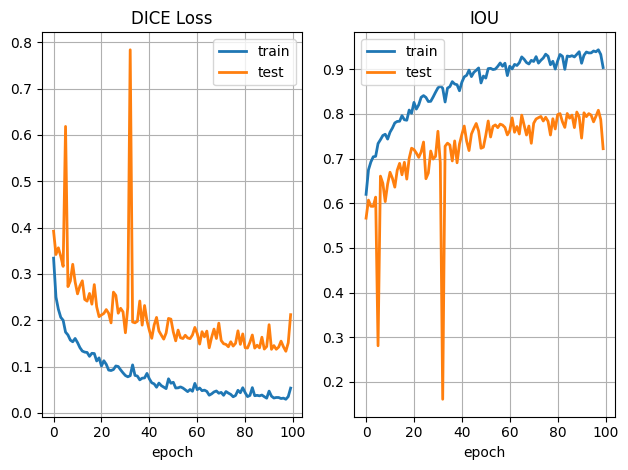

In [19]:
import matplotlib.pyplot as plt

loss, iou, lr = metrics
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.plot(loss["train"], label="train", lw=2)
ax1.plot(loss["test"], label="test", lw=2)
ax1.set_title("DICE Loss")

ax2.plot(iou["train"], label="train", lw=2)
ax2.plot(iou["test"], label="test", lw=2)
ax2.set_title("IOU")

for ax in ax1, ax2:
    ax.grid(True)
    ax.set_xlabel("epoch")
    ax.legend()

plt.tight_layout()
plt.show()

# Lets try achieve >= 0.87 IoU with pretrained classification model

In [14]:
from torchvision.models import resnet34, ResNet34_Weights

class ResNetUp(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
    def forward(self, x1, x2):
        x = self.up(x1) + x2
        return x

class OutConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv_sigm = nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.conv_sigm(x)

class ResNetEncoderDecoder(nn.Module):
    def __init__(self, n_classes=1):
        super().__init__()
        pretrained = resnet34(weights=ResNet34_Weights.DEFAULT)
        self.inconv = nn.Sequential(
            pretrained.conv1,
            pretrained.bn1,
            pretrained.relu
        )
        self.maxpool = pretrained.maxpool
        self.down1 = pretrained.layer1
        self.down2 = pretrained.layer2
        self.down3 = pretrained.layer3
        self.down4 = pretrained.layer4

        channels = [
            pretrained.conv1.out_channels, 
            pretrained.layer1[-1].bn2.num_features, 
            pretrained.layer2[-1].bn2.num_features,
            pretrained.layer3[-1].bn2.num_features, 
            pretrained.layer4[-1].bn2.num_features
        ]
        self.up1 = ResNetUp(channels[-1], channels[-2])
        self.up2 = ResNetUp(channels[-2], channels[-3])
        self.up3 = ResNetUp(channels[-3], channels[-4])
        self.up4 = ResNetUp(channels[-4], channels[-5])
        self.outconv = OutConv(channels[-5], n_classes)

    def forward(self, x):
        x1 = self.inconv(x)
        x1_mp = self.maxpool(x1)
        x2 = self.down1(x1_mp)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)    
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outconv(x)
        return x

In [15]:
from torch.utils.data import DataLoader
import albumentations as A

X_train = get_paths("data/train/images/")
y_train = get_paths("data/train/gt")
X_test = get_paths("data/test/images/")
y_test = get_paths("data/test/gt")

train_augs = A.Compose(
    [
        A.HorizontalFlip(),
        A.GaussNoise(var_limit=(1e-4, 1e-4)),
        A.Perspective(pad_mode=1, p=0.3),
        A.ShiftScaleRotate(rotate_limit=(0.5, 0.5), scale_limit=(-0.2, 0.2), border_mode=0, p=0.7),
        A.ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), hue=(-0.03, 0.03), saturation=(0.95, 1.5)),
        A.PadIfNeeded(min_height=512, min_width=512, border_mode=0)
    ],
)

test_augs = A.Compose(
    [
        A.PadIfNeeded(min_height=512, min_width=512, border_mode=0)
    ],
)

transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = RoadDataset(X_train, y_train, transform, train_augs)
test_dataset = RoadDataset(X_test, y_test, transform, test_augs)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [17]:
device="cuda:1"
num_epochs = 100
prediction_thr = 0.5
loss_fn = DICELoss()
model = ResNetEncoderDecoder().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.8, min_lr=1e-5, threshold=1e-2)
metrics = train(num_epochs, model, train_loader, test_loader, optimizer, loss_fn, prediction_thr, device, scheduler=scheduler)

Epoch 0 	 || 	 Train|Test Loss: 0.591|0.366 	 || 	 Train|Test IOU: 0.293|0.599 	 || 	 LR: 0.0001
Epoch 1 	 || 	 Train|Test Loss: 0.167|0.224 	 || 	 Train|Test IOU: 0.730|0.696 	 || 	 LR: 0.0001
Epoch 2 	 || 	 Train|Test Loss: 0.128|0.201 	 || 	 Train|Test IOU: 0.779|0.726 	 || 	 LR: 0.0001
Epoch 3 	 || 	 Train|Test Loss: 0.106|0.189 	 || 	 Train|Test IOU: 0.813|0.744 	 || 	 LR: 0.0001
Epoch 4 	 || 	 Train|Test Loss: 0.103|0.159 	 || 	 Train|Test IOU: 0.819|0.774 	 || 	 LR: 0.0001
Epoch 5 	 || 	 Train|Test Loss: 0.087|0.157 	 || 	 Train|Test IOU: 0.843|0.779 	 || 	 LR: 0.0001
Epoch 6 	 || 	 Train|Test Loss: 0.084|0.145 	 || 	 Train|Test IOU: 0.848|0.796 	 || 	 LR: 0.0001
Epoch 7 	 || 	 Train|Test Loss: 0.079|0.144 	 || 	 Train|Test IOU: 0.856|0.799 	 || 	 LR: 0.0001
Epoch 8 	 || 	 Train|Test Loss: 0.068|0.145 	 || 	 Train|Test IOU: 0.875|0.798 	 || 	 LR: 0.0001
Epoch 9 	 || 	 Train|Test Loss: 0.075|0.127 	 || 	 Train|Test IOU: 0.864|0.814 	 || 	 LR: 0.0001
Epoch 10 	 || 	 Train|Test Los

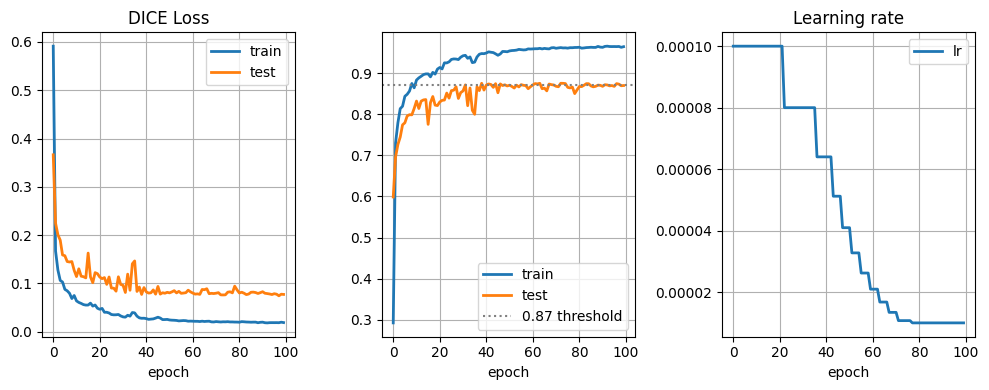

In [35]:
import matplotlib.pyplot as plt

loss, iou, lr = metrics
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

ax1.plot(loss["train"], label="train", lw=2)
ax1.plot(loss["test"], label="test", lw=2)
ax1.set_title("DICE Loss")

ax2.plot(iou["train"], label="train", lw=2)
ax2.plot(iou["test"], label="test", lw=2)
ax2.axhline(0.87, ls=":", label="0.87 threshold", c="grey")
ax3.set_title("IOU")

ax3.plot(lr, label="lr", lw=2)
ax3.set_title("Learning rate")

for ax in ax1, ax2, ax3:
    ax.grid(True)
    ax.set_xlabel("epoch")
    ax.legend()

plt.tight_layout()
plt.show()